# IMDb Movie Reviews Sentiment Classification

The data is uploaded and in the form of training and testing data, each with 25000 reviews. First we extract the data from the folders and preprocess it.

# Data Extraction and Preprocessing

The data is taken from the site given below which contains IMDb reviews of different movies classified as positive(1) or negative(0).

In [8]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!tar -xf cc.en.300.bin.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

def GetTextFilePathsInDirectory(directory):
    files = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            filePath = os.path.join(directory, file)
            files.append(filePath)
    return files

def GetLinesFromTextFile(filePath):
    with open(filePath,"r", encoding="utf-8") as f:
        lines = [line.strip() for line in f]
    return lines

# The two directories, train and test, each contain two directories, one with all the positive reviews and one with the negative ones
# The data is in the form of many files, each file contains one review

positive_files = GetTextFilePathsInDirectory("aclImdb/train/pos/")
positive_files += GetTextFilePathsInDirectory("aclImdb/test/pos/")
negative_files = GetTextFilePathsInDirectory("aclImdb/train/neg/")
negative_files += GetTextFilePathsInDirectory("aclImdb/test/neg/")

# Extracting the reviews from the files
reviews_positive = []
for i in range(0,len(positive_files)):
    reviews_positive.extend(GetLinesFromTextFile(positive_files[i]))
    
reviews_negative = []
for i in range(0,len(negative_files)):
    reviews_negative.extend(GetLinesFromTextFile(negative_files[i]))

print("Number of positive reviews available :", len(reviews_positive))
print("Number of negative reviews available :", len(reviews_negative))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.9M      0  0:00:07  0:00:07 --:--:-- 18.3M
Number of positive reviews available : 25000
Number of negative reviews available : 25000


# Cleaning the data
Since the data contains html tags like \<br> etc. and other unimportant parts, we will remove them and convert the data to trainable form.

In [9]:
import nltk
# nltk.download("stopwords")
# from nltk.corpus import stopwords
import re
import numpy as np

# Replace HTML markup on the reviews with space, and characters such as \ without space
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|()|()|()|()")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    default_stop_words = nltk.corpus.stopwords.words('english')
    stopwords = set(default_stop_words)
    
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    # reviews = [RemoveStopWords(line,stopwords) for line in reviews]
    
    return reviews

# Remove the stopwords
# def RemoveStopWords(line, stopwords): # DONT USE STOPWORDS
#     words = []
#     for word in line.split(" "):
#         word = word.strip()
#         word = word.lower()
#         if word not in stopwords and word != "" and word != "&":
#             words.append(word)

#     return " ".join(words)

reviews_positive = preprocess_reviews(reviews_positive)
reviews_negative = preprocess_reviews(reviews_negative)

# Combine the original training and test data so we can choose test size as per our requirement
Reviews_Labeled = list(zip(reviews_positive, np.ones(len(reviews_positive))))
Reviews_Labeled.extend(list(zip(reviews_negative, np.zeros(len(reviews_negative)))))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# WordCloud Visualization

['see', 'well', 'story', 'one', 'even', 'show', 'way', 'scene', 'time', 'people', 'character', 'movie', 'make', 'much', 'think', 'film']


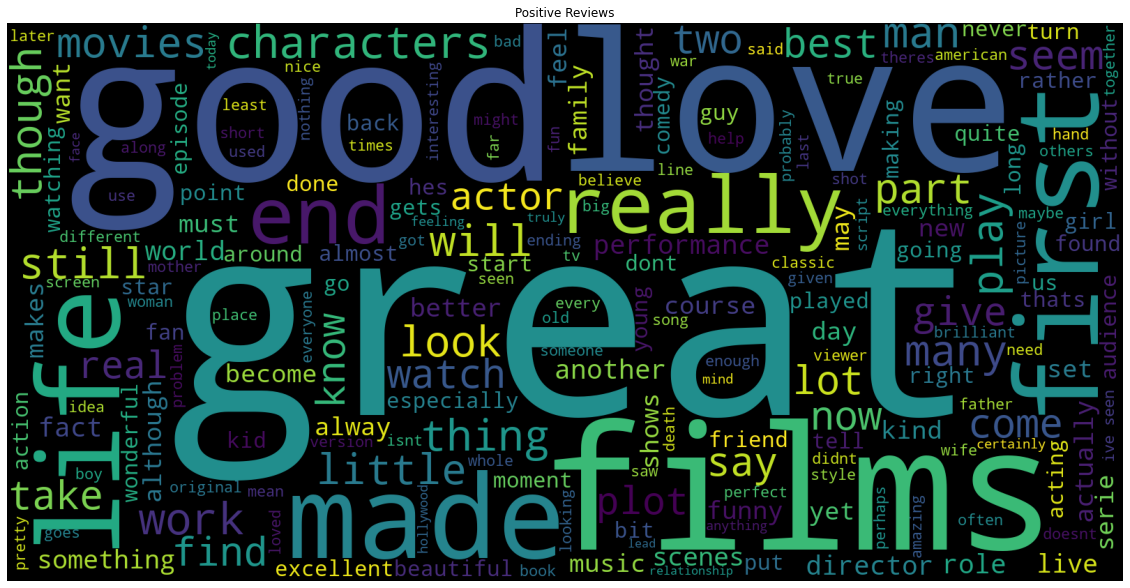

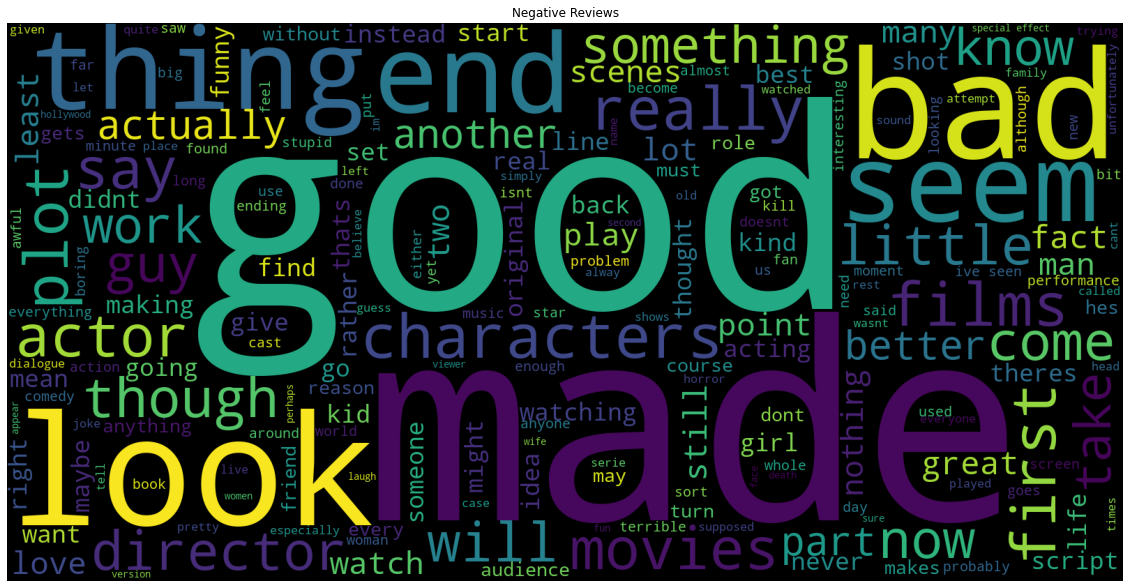

In [10]:
from wordcloud import WordCloud, STOPWORDS

pos = " ".join(reviews_positive)
neg = " ".join(reviews_negative)

wc_pos = WordCloud(width = 1600, height = 800,).generate(pos)

wc_neg = WordCloud(width = 1600, height = 800,).generate(neg) 

top_words = 20
top_pos = list(wc_pos.words_.keys()) # Sorted in decr order of frequencies
top_neg = list(wc_neg.words_.keys())
common = list(set(top_pos[:top_words]) & set(top_neg[:top_words]))
print(common)

remove_words = ['movie', 'see', 'character', 'one', 'well', 'film', 'show', 'people', 'scene', 'time', 'even', 'make', 'think', 'way', 'story', 'much']
stopwords = set(STOPWORDS).union(set(remove_words))

wc_pos = WordCloud(width = 1600, height = 800, stopwords = stopwords).generate(pos)

wc_neg = WordCloud(width = 1600, height = 800, stopwords = stopwords).generate(neg) 

plt.figure(figsize = (20,20))
plt.imshow(wc_pos) # COMPARE TOP 20 WORDS AND REMOVE COMMON WORDS
plt.title("Positive Reviews")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neg)
plt.title("Negative Reviews")
plt.axis("off")
plt.show()

# Sequence Length
First we need to find an appropriate output sequence length for our model. TO find this we do the following :

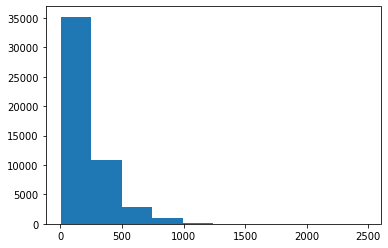

Average length of each review is : 232.04
Standard deviation of length of each review is : 172.13
We take the length of the sequence to be mean + 3*std which becomes :  748


In [11]:
lengths = []
for text, label in Reviews_Labeled :
  lengths.append(len(text.split(" "))) # Store number of words in each review in a list "lengths"
plt.hist(lengths)
plt.show()
mean = np.mean(lengths)
std = np.std(lengths)
sequence_length = int(mean + 3*std)

print("Average length of each review is : %0.2f"%mean)
print("Standard deviation of length of each review is : %0.2f"%std)
print("We take the length of the sequence to be mean + 3*std which becomes : ",sequence_length)

# Dividing the data in Training and Testing

In [16]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence 

train, test = train_test_split(Reviews_Labeled, test_size = 0.2)

X_train, y_train = list(zip(*train))
X_test, y_test = list(zip(*test))

y_train = np.array(y_train)
y_test = np.array(y_test)

# Tokenizing and Constructing Embedding Matrix

In [17]:
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm

def getTokenizer():
    tok = Tokenizer()
    # Create word_index and vocab
    tok.fit_on_texts(X_train)
    return tok

tok = getTokenizer()
word_index = tok.word_index
N_vocab = len(tok.word_index) + 1
N_EMB = 300

X_train = sequence.pad_sequences(tok.texts_to_sequences(X_train), maxlen = sequence_length)
X_test = sequence.pad_sequences(tok.texts_to_sequences(X_test), maxlen = sequence_length) # TRY PRE PADDING

embeddings_index = {}
with open("cc.en.300.txt", "r", errors="ignore") as f: # TRY FAST TEXT, 100D
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((N_vocab, N_EMB))
n_match = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        n_match += 1
        embedding_matrix[i] = embedding_vector

print("Vocabulary size :",N_vocab)
print("Number of common words :",n_match)

47878it [00:01, 32409.20it/s]


Vocabulary size : 117369
Number of common words : 16400


# The Model
We are using bidirectional LSTM ...

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM, Bidirectional, Dropout, Flatten, BatchNormalization
import keras 

# Sequential model is used as the input data is text
model = Sequential()

# Define the embedding layer
model.add(Embedding(N_vocab, N_EMB, weights = [embedding_matrix], input_length = sequence_length, trainable = False))

# We add a Bidirectional LSTM layer with 100 hidden units
model.add(Bidirectional(LSTM(100, dropout = 0.2, return_sequences = True))) # CHECK WITHOUT BIDIRECTIONAL, LSTM ARGUMENTS

# ADD ONE MORE LAYER OF LSTM
model.add(Bidirectional(LSTM(100, dropout = 0.2, return_sequences = True)))

# ADD FLATTEN LAYER, BATCH NORMALIZATION
model.add(Flatten())
model.add(BatchNormalization(momentum = 0.9))

# Add two dense layers
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

# Since it is a binary classification, we use binary cross entropy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 748, 100)          11736900  
_________________________________________________________________
bidirectional (Bidirectional (None, 748, 200)          160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 748, 200)          240800    
_________________________________________________________________
flatten (Flatten)            (None, 149600)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 149600)            598400    
_________________________________________________________________
dense (Dense)                (None, 32)                4787232   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [19]:
num_epochs = 3

# Fit the model using the train and test datasets.
r = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = num_epochs)

Epoch 1/3
1250/1250 [==============================] - 646s 508ms/step - loss: 1.5177 - accuracy: 0.7151 - val_loss: 0.4456 - val_accuracy: 0.8015
Epoch 2/3
1250/1250 [==============================] - 634s 507ms/step - loss: 0.3983 - accuracy: 0.8214 - val_loss: 0.4294 - val_accuracy: 0.7951
Epoch 3/3
1250/1250 [==============================] - 636s 509ms/step - loss: 0.3643 - accuracy: 0.8421 - val_loss: 0.3118 - val_accuracy: 0.8704


In [20]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 56s 180ms/step - loss: 0.3118 - accuracy: 0.8704


[0.31177282333374023, 0.8704000115394592]

Text(0.5, 1.0, 'Loss function evolution')

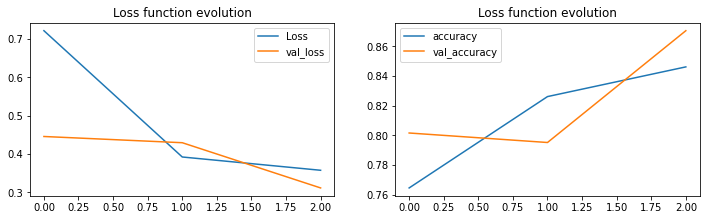

In [21]:
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss function evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Loss function evolution')